# Inference Notebook

This notebook demonstrates the trained image captioning model. It loads the saved model artifacts and performs inference on images.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision import models
from PIL import Image
import pickle
import os
import matplotlib.pyplot as plt
from IPython.display import display

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Model Definitions

In [44]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: '<pad>', 1: '<start>', 2: '<end>', 3: '<unk>'}
        self.stoi = {'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        import re
        text = text.lower()
        text = re.sub(r'[^a-z0-9\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text.split(' ')

    def decode(self, ids, skip_special_tokens=True):
        if skip_special_tokens:
            tokens = [self.itos.get(i, '<unk>') for i in ids if i not in [0, 1, 2]]
        else:
            tokens = [self.itos.get(i, '<unk>') for i in ids]
        return ' '.join(tokens)

class EfficientNetEncoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        effnet = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)
        self.backbone = effnet.features
        self.avgpool = effnet.avgpool
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.projection = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1408, embed_size),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

    def forward(self, images):
        with torch.no_grad():
            x = self.backbone(images)
            x = self.avgpool(x)
        return self.projection(x)

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.encoder = EfficientNetEncoder(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def caption_image(self, image, vocabulary, max_length=50):
        self.eval()
        result_caption = []
        with torch.no_grad():
            x = self.encoder(image).unsqueeze(1)
            states = None
            hiddens, states = self.decoder.lstm(x, states)
            next_word = torch.tensor([[vocabulary.stoi['<start>']]]).to(image.device)

            for _ in range(max_length):
                embeds = self.decoder.embedding(next_word)
                hiddens, states = self.decoder.lstm(embeds, states)
                output = self.decoder.linear(hiddens[:, -1, :])
                predicted = output.argmax(dim=1)
                item = predicted.item()
                if item == vocabulary.stoi['<end>']: break
                result_caption.append(vocabulary.itos[item])
                next_word = predicted.unsqueeze(1)
        return result_caption

    def caption_image_beam_search(self, image, vocabulary, k=5, max_length=50):
        # maybe will improve captioning a little, probably not, tuning efficientnet is needed
        self.eval()
        with torch.no_grad():
            x = self.encoder(image).unsqueeze(1)

            states = None
            hiddens, states = self.decoder.lstm(x, states)

            start_token = vocabulary.stoi['<start>']
            candidates = [(0, [start_token], states)]

            for _ in range(max_length):
                new_candidates = []
                for score, seq, (h, c) in candidates:
                    if seq[-1] == vocabulary.stoi['<end>']:
                        new_candidates.append((score, seq, (h, c)))
                        continue

                    word_input = torch.tensor([[seq[-1]]]).to(image.device)
                    embeds = self.decoder.embedding(word_input)

                    h_out, (h_new, c_new) = self.decoder.lstm(embeds, (h, c))
                    outputs = self.decoder.linear(h_out.squeeze(0))
                    log_probs = F.log_softmax(outputs, dim=1)

                    top_log_probs, top_indices = log_probs.topk(k, dim=1)

                    for i in range(k):
                        word_idx = top_indices[0][i].item()
                        log_prob = top_log_probs[0][i].item()
                        new_candidates.append((score + log_prob, seq + [word_idx], (h_new, c_new)))

                candidates = sorted(new_candidates, key=lambda x: x[0], reverse=True)[:k]

                if all(c[1][-1] == vocabulary.stoi['<end>'] for c in candidates):
                    break

            best_seq = candidates[0][1]
            result_caption = [vocabulary.itos[idx] for idx in best_seq if idx not in [vocabulary.stoi['<start>'], vocabulary.stoi['<end>']]]
            return result_caption

In [45]:
# could be modified
# didnt get saved for whatever reason in training
class Config:
    # Paths
    IMAGE_DIR = "caption_data/Images"
    CAPTIONS_FILE = "caption_data/captions.txt"
    FEATURES_PATH = "caption_data/resnet_features.pt"
    VOCAB_PATH = "vocab.pkl"

    # Model
    EMBED_SIZE = 256
    HIDDEN_SIZE = 512
    NUM_LAYERS = 1
    DROPOUT = 0.5

    NUM_WORKERS = 2 if torch.cuda.is_available() else 0

    # Training
    BATCH_SIZE = 64
    EPOCHS = 20
    LEARNING_RATE = 3e-4
    WEIGHT_DECAY = 1e-5
    GRAD_CLIP = 5.0

    # Data
    FREQ_THRESHOLD = 5  # could be modified
    MAX_SEQ_LEN = 50 # I don't think we need to use this

    # Splits
    TRAIN_SPLIT = 0.8
    VAL_SPLIT = 0.1

cfg = Config()

## Load Model

In [46]:
checkpoint_path = '/content/drive/My Drive/final_model.pth.tar'
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    vocab = checkpoint['vocab']
    model = CNNtoRNN(cfg.EMBED_SIZE, cfg.HIDDEN_SIZE, len(vocab), cfg.NUM_LAYERS).to(device)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    print('Model loaded')
else:
    print('Model not found')

Model loaded


## Inference Function

In [47]:
def generate_caption(image_path: str, model: any, beam_search: bool = True, k: int = 5) -> str:
    transforms = T.Compose([
        T.Resize((260, 260)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(image_path).convert('RGB')
    img_tensor = transforms(img).unsqueeze(0).to(device)

    if beam_search:
        caption_list = model.caption_image_beam_search(img_tensor, vocab, k=k)
    else:
        caption_list = model.caption_image(img_tensor, vocab)

    return ' '.join(caption_list)

## Demo

Using 1619 validation images from /content/drive/My Drive/val_images.json
Image: 3221815947_76c95b50b7.jpg
Caption (Beam k=5): a black and white dog is running through a field


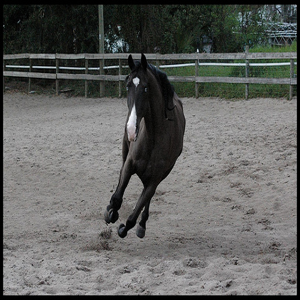

Image: 3705976184_53ae07e898.jpg
Caption (Beam k=5): a man and a dog are running through a field


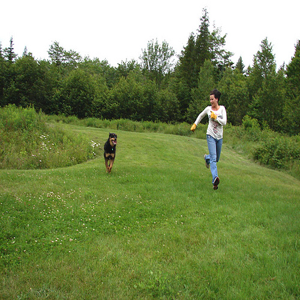

Image: 2937497894_e3664a9513.jpg
Caption (Beam k=5): a skateboarder does a trick on a ramp


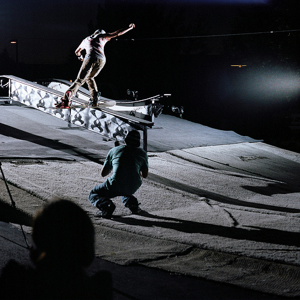

In [60]:
test_image_dir = '/content/drive/My Drive/caption_data/Images'
val_list_path = '/content/drive/My Drive/val_images.json'

if os.path.exists(test_image_dir):
    import random
    import json

    if os.path.exists(val_list_path):
        with open(val_list_path, 'r') as f:
            val_images = json.load(f)

        all_imgs = [x for x in val_images if os.path.exists(os.path.join(test_image_dir, x))]
        print(f'Using {len(all_imgs)} validation images from {val_list_path}')
    else:
        print('Validation list not in path, sampling from all images')
        all_imgs = [f for f in os.listdir(test_image_dir) if f.lower().endswith(('.jpg'))]

    if all_imgs:
        sample = random.sample(all_imgs, min(3, len(all_imgs)))
        for img_name in sample:
            path = os.path.join(test_image_dir, img_name)
            print(f'Image: {img_name}')
            print(f'Caption (Beam k=5): {generate_caption(path, model, beam_search=True, k=5)}')
            display(Image.open(path).resize((300, 300)))
    else:
        print('No images found.')
else:
    print('Image directory not found.')